### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [1]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Learning
from clustering import Clustering

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db = PythonProblems('python.sqlite')

In [3]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
docs_id = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, row in enumerate(cursor.fetchall()):
    file = io.StringIO(row[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(row[0])

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [4]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(753, 16)

In [5]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
solution_sample.shape

(750, 16)

### Cluster solutions

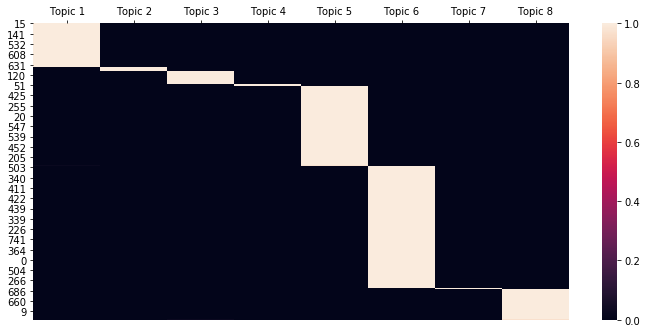

In [26]:
clustering = Clustering(solution_sample, 8)
model, document_topic, word_topic = clustering.gaussian_mixture()
clustering.plot_topic_distribution()

In [33]:
np.random.RandomState().get_state()

('MT19937', array([3942021341, 2559610341, 2123749344, 3595353302,  715861058,
        3299072022, 3183130135, 1454888680, 3944312100, 1578715672,
        1770395631, 2817084010, 4065991960,  998893951, 3747417617,
        2776650171, 3033526613, 2890586051, 1676908266, 2691748698,
         455818622,   11214744, 2184360402, 2913938233, 3559966712,
        1333355922, 2929333120, 2898482206,  912746822,  887660006,
        1789997247, 3236539593,  794971692, 3375499849, 1843235110,
        3583850294, 2426568665,  446157486, 1536518304,  464736729,
        1520325815,  517844199, 4106350485, 4153203273,  373954747,
        1514693647, 3615968301, 1228900934, 2285555994,  724164763,
        1200532938, 2148762603, 2514608337,  268640701,  605935513,
        2151103382,  268564224,  312501461, 3106491200, 1544251668,
        2336427691,   95570662, 2543730734,  753625785,  614608804,
        1762099558,  335798844, 3747188108, 3592145145, 3732927897,
         233955420, 3261324781,  8045

### Get next sample

In [ ]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = numpy.zeros(solution_sample.shape[0], )
# Save X
X_path = os.path.join('../User-Data/X_' + str(user_id) + '.npy')
numpy.save(X_path, X)
# Set L as an unlabelled set
L = []
request.session['L'] = L

In [ ]:
########################################################################
# Date: June 2015
# Author: Edward Johns (e.johns@imperial.ac.uk)
# This code may be freely distributed, but citations should be made to:
# E. Johns et al, "Becoming the Expert - Interactive Multi-Class Machine Teaching", in Proceedings of CVPR 2015
########################################################################



import numpy as np

def get_next_sample(X, Y, W, L):

    # Based on "Zhu et al., Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions, in ICML workshop 2003"

    # Input:
    # Below, nS = total number of samples, nC = number of classes, nL = number of observed samples, nT = total number of testing samples to be shown to user
    # X: nS*nC belief matrix, with each row representing one sample, and each column representing one column. Each element is the probability that the user thinks that sample is assigned to that class. This would be identical to Y if we were assuming that the user always assigns the ground truth to an observed sample, and never has memory fall-off.
    # Y: nS*nC ground truth matrix (NumPy array), with each row in indicator encoding. This represents the ground-truth labels of all points. As such, each row has only one "1" and all other entries are "0".
    # W: nS*nS graph weights matrix (symmetrical NumPy array), with each row and each column corresponding to one sample. Each element is the weight (affinity) between two samples.
    # L: nL*1 labeled set, where each element is one sample that has already been shown to the user, with indices between 1 and nS.
    # testing_samples: nT*1 testing set, where each element is one sample that will (or has already been) shown to the user as a testing image. This is to prevent testing images being shown during teaching.
    # mode: the teaching mode (2 = worst predicted, 3 = our method)
    # Output:
    #    next_sample: the index of the optimum sample to be shown next, as selected by the active teaching algorithm.

    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape

    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)

    # Get the number of unlabelled samples (nU)
    nU = len(U)

    # Get the ground truth for the unlabelled samples
    Yu = Y.take(U, 0)

    # Get the unlabelled section of the covariance matrix
    Delta = np.subtract(np.diag(np.sum(W, 1)), W)
    invDeltaU = np.linalg.inv(Delta.take(U, 0).take(U, 1))

    # Get the current state of the GRF, for the unlabelled samples
    f = np.dot(invDeltaU, np.dot(W.take(U, 0).take(L, 1), X.take(L, 0)))

    # Create a list of risks, one for each unlabelled sample
    uRisks = np.zeros(nU)

    # Try each unlabelled sample
    for u in range(nU):
        # Find the sample number (remember that U is just the list of unlabelled samples, not all the samples)
        s = U[u]

        # If the sample is a testing image, then ignore it (by assigning a very high risk)
        if s in testing_samples:
            uRisks[u] = 10000
            continue

        # Calculate the new state of the GRF if this sample were to be revealed to the user (here, we assume that the user's belief of this sample will then be the ground truth -- debatable...)
        GG = invDeltaU[:, u] / invDeltaU[u, u]
        diff = Y[s, :] - f[u, :]
        fPlus = f + np.dot(GG[..., np.newaxis], diff[np.newaxis, ...])

        # Sum up the risks over all unlabelled points (i.e. the difference between the new state, and the ground truth)
        D = np.abs(1 - fPlus[Yu == 1])
        uRisks[u] = np.sum(D)

    # Get the sample which minimised the risk
    next_sample_index = np.argmin(uRisks)
    next_sample = U[next_sample_index]

    # Return this sample
    return next_sample

### Calculate similarity matrix 

In [131]:
# Get pairwise similarity
dist = cosine_similarity(X)

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).